# Попытка разобраться в причинах московского безумия - реновации
А заодно упражнение на освоение визуализации различных данных на картах<br/>

## Гипотеза
Реновация обосновывается ветхостью сносимого жилищного фонда. Так же, как и его "моральным износом".<br/>
На основе открытых данных попробуем оценить ветхость домов

## Источники данных:
<ul>
<li>https://www.reformagkh.ru - паспорта домов и их гео-координаты. Сайт госкорпорации - Фонда содействия реформированию ЖКХ. См. "Стандарт раскрытия" - официальный сайт раскрытия информации о ЖКХ</li>
<li>http://www.consultant.ru/document/cons_doc_LAW_1927/3af943730cff040542944e236761333704bd43e2/ - коэффициенты амортизационных отчислений</li>
<li>http://tipdoma.ru/list1.html - серии многоквартирных жилых домов</li>
<li>https://ru.wikipedia.org/wiki/%D0%A1%D0%B5%D1%80%D0%B8%D0%B8_%D0%B6%D0%B8%D0%BB%D1%8B%D1%85_%D0%B4%D0%BE%D0%BC%D0%BE%D0%B2 - серии многоквартирных жилых домов</li>
</ul>
<p>Для скачивания данных используется следующий скрипт - https://github.com/GeorgyGol/read_tor_aigk</p>

<p>интересная дискуссия об оценки степени износа жилых домов - http://www.consultant.ru/document/cons_doc_LAW_1927/3af943730cff040542944e236761333704bd43e2/ <br/><br/>
http://docs.cntd.ru/document/871001224 - ВСН 58-88(р) Положение об организации и проведении реконструкции, ремонта и технического обслуживания зданий, объектов коммунального и социально-культурного назначения.</p>
<p><i>"Сроки проведения ремонта зданий, объектов или их элементов должны определяться на основе оценки их технического состояния."</i></p>
<p><i>"3. Решение о необходимости проведения капитального ремонта или об отсутствии такой необходимости рекомендуется принимать в момент принятия решения о включении (невключении) многоквартирного дома в региональную программу капитального ремонта общего имущества в многоквартирных домах (далее - региональная программа капитального ремонта) формируемую и актуализируемую в порядке, установленном нормативным правовым актом субъекта Российской Федерации для формирования и актуализации региональных программ капитального ремонта"</i></p><br/>
http://www.garant.ru/products/ipo/prime/doc/70629300/#ixzz4hzzaGvmr" - жилищный кодекс РФ<br/>
<p><i>...Общие осмотры должны проводиться два раза в год: весной и осенью...</i></p>
<p><i>...Общие осмотры жилых зданий должны осуществляться комиссиями в составе представителей жилищно-эксплуатационных организаций и домовых комитетов (представителей правлений жилищно-строительных кооперативов)...</i></p>
<p><i>...Результаты осмотров следует отражать в документах по учету технического состояния здания или объекта (журналах учета технического состояния, специальных карточках и др.). В этих документах должны содержаться: оценка технического состояния здания или объекта и его элементов, выявленные неисправности, места их нахождения, причины, вызвавшие эти неисправности, а также сведения о выполненных при осмотрах ремонтах... </i></p>
<p><i>...Обобщенные сведения о состоянии здания или объекта должны ежегодно отражаться в его техническом паспорте...</i></p> <br/>
Паспорт дома публикуется на сайте https://www.reformagkh.ru

http://logos-pravo.ru/chto-takoe-vethoe-zhile-otlichie-ot-zhilya-avariynogo - о понятии "ветхое жилье"

In [217]:
import folium
import pandas as pd
import re
from datetime import datetime as dt
import numpy as np

#коэффициенты амортизационных отчислений

#k_amo={'panel': (0.7, ('панел',)), 
#       'brick': (0.8, ('кирпич', 'кирич', 'кирпин')), 
#       'monolit': (1, ('монолит',)), 
#       'block':(1, ('блоч', 'газобетон', 'шлак', 'газосили')), 
#       'log':(2.2, ('дерев', 'бревен', 'щитов')), 
#       'clay':(3.3, ('глин',)), 
#       'carcas': (6.6, ('саман','каркасно-засыпной',)), 
#       'mixt':(0.7, ('смешан',)), 
#       'other':(1, ('иные',)),
#       'bad_series':(0.3, ('К-7', 'K-7', 'К-6', 'K-6', r'1605-AM/5', r'1605-AM/5',
#                                'II-32', 'II-35', '1605-AM', '1605-AM', '1-МГ-300', '1-MГ-300'))}

# коэффициенты срока жизни здания. Срок жизни = 100 * коэфф.
k_amo={'panel': (0.7, ('панел',)), 
       'brick': (1.0, ('кирпич', 'кирич', 'кирпин')), 
       'monolit': (1.5, ('монолит',)), 
       'block':(1, ('блоч', 'газобетон', 'шлак', 'газосили')), 
       'log':(0.22, ('дерев', 'бревен', 'щитов')), 
       'clay':(0.33, ('глин',)), 
       'carcas': (0.66, ('саман','каркасно-засыпной',)), 
       'mixt':(0.7, ('смешан',)), 
       'other':(1, ('иные',)),
       'bad_series':(0.3, ('К-7', 'K-7', 'К-6', 'K-6', r'1605-AM/5', r'1605-AM/5',
                                'II-32', 'II-35', '1605-AM', '1605-AM', '1-МГ-300', '1-MГ-300'))}

null_val={'Не заполнено': np.nan}

k_dila=0.7 #порог ветхости - все, что больше - ветхое

In [220]:
#dtfHouses=pd.read_csv(r'/home/egor/data/Houses/vlad_obl_houses.csv', encoding='cp1251', sep=';', index_col='id')
#dtfHouses=pd.read_csv(r'Houses/vlad_obl_houses.csv', encoding='cp1251', sep=';', index_col='id')
#dtfHouses=pd.read_csv(r'Houses/tula_houses.csv', encoding='cp1251', sep=';', index_col='id')
#dtfHouses=pd.read_csv(r'Houses/piter_houses.csv', encoding='cp1251', sep=';', index_col='id')
dtfHouses=pd.read_csv(r'Houses/moscow_houses.csv', encoding='cp1251', sep=';', index_col='id')
#dtfHouses=pd.read_csv(r'Houses/mos_obl_houses.csv', encoding='cp1251', sep=';', index_col='id')

#print(dtfHouses.columns.tolist())

In [293]:
#cleaning and prepare data

lst_work1=['address', 'year', 'build_year', 'floors', 'seria', 'working_year',
           'type', 'wall_type', 'latitude', 'longtitude', 'wreck', 'rooms', 'living_square', 'common_hold_square']


def clean_for_research1(dtfm):
    dtf=dtfm[lst_work1]
    dtf['year']=dtf[['build_year', 'working_year']].replace(null_val).astype(float).max(axis=1)
    dtf['wreck']=dtf['wreck'].apply(lambda x: x.lower() =='да')
    dtf.drop(['build_year', 'working_year'], axis=1, inplace=True)
    #tula specific, moscow specific
    dtf['seria']=dtf['seria'].str.upper()
    dtf.replace({'year':{960:1960, 2975:1975, 2850:1850}, 
                 'seria':{'НЕТ':'НЕ ЗАПОЛНЕНО', 'НЕ УКАЗАН':'НЕ ЗАПОЛНЕНО', 'Б/Н':'НЕ ЗАПОЛНЕНО', 'ПОВТ. ПРИМ.':'НЕ ЗАПОЛНЕНО',
                          'ТИПОВОЙ':'НЕ ЗАПОЛНЕНО', 'НЕ ПРИСВОЕН':'НЕ ЗАПОЛНЕНО', 'ПОВТ.ПРИМ.':'НЕ ЗАПОЛНЕНО',
                          'НЕТ ДАНЕНЫХ':'НЕ ЗАПОЛНЕНО', 'Н/Д':'НЕ ЗАПОЛНЕНО', '----':'НЕ ЗАПОЛНЕНО', 'ПАНЕЛЬНЫЙ (LL-49)':'II-49',
                          'ПОВТ.ПРИМ':'НЕ ЗАПОЛНЕНО', 'ЖИЛОЙ,':'НЕ ЗАПОЛНЕНО', 'ЖИЛОЙ':'НЕ ЗАПОЛНЕНО', 'НЕ ОПРЕДЕЛЕНО':'НЕ ЗАПОЛНЕНО', 
                          'НЕТ ДАННЫХ':'НЕ ЗАПОЛНЕНО', '-':'НЕ ЗАПОЛНЕНО', 'ОТСУТСТВУЕТ':'НЕ ЗАПОЛНЕНО','ПОВТ.ПР.':'НЕ ЗАПОЛНЕНО', 
                          'ПОВТОРНЫЙ ПРОЕКТ':'НЕ ЗАПОЛНЕНО', 'ОТСУТСТВУЮТ ПОДТВЕРЖДАЮЩИЕ ДОКУМЕНТЫ':'НЕ ЗАПОЛНЕНО', 'ЖИЛОЕ':'НЕ ЗАПОЛНЕНО', 
                          'ПОВТОРНОГО ПРИМЕНЕНИЯ':'НЕ ЗАПОЛНЕНО', 'ПОВТОРНО ПРИМИНИМ.':'НЕ ЗАПОЛНЕНО','НЕТ ИНФОРМАЦИИ':'НЕ ЗАПОЛНЕНО',
                          'ИНВИДУАЛЬНЫЙ ПРОЕКТ':'ИНД', 'ЖИЛОЙ.':'НЕ ЗАПОЛНЕНО', 'НЕ УКАЗАННО':'НЕ ЗАПОЛНЕНО','МНДИВИДУАЛЬНЫЙ':'ИНД',
                          'ИНЖИВИДУАЛЬНЫЙ':'ИНД', 'НЕ ИМЕЕТСЯ':'НЕ ЗАПОЛНЕНО', 'ИНАЯ':'НЕ ЗАПОЛНЕНО','ТИПОВЫЙ':'НЕ ЗАПОЛНЕНО',
                          'НЕТИПОВАЯ ЗАСТРОЙКА':'ИНД','НЕ УСТАНОВЛЕН':'НЕ ЗАПОЛНЕНО', 'ПЯТИЭТАЖНЫЙ':'НЕ ЗАПОЛНЕНО', 'ЭКПЕРИМ.':'ИНД',
                          'ЭКСПЕРИМЕНТАЛЬНЫЙ':'ИНД', 'ИНОЙ':'НЕ ЗАПОЛНЕНО','ПОВТОРНОЕ ПРИМЕНЕНИЕ':'НЕ ЗАПОЛНЕНО',
                          '17-ТИ ЭТАЖНЫЙ 3-Х СЕКЦИОННЫЙ ЖИЛОЙ ДОМ НА БАЗЕ БЛОК-СЕКЦИЙ СИСТЕМЫ ГМС-2001 С ПЕРВЫМ ЖИЛЫМ ЭТАЖОМ':'ГМС-2001'}},  
                inplace=True)
    
    #dtf['seria']=dtf['seria'].str.replace(r'II', 'П')
    #dtf['seria']=dtf['seria'].str.replace(r'I', '1')
    #dtf['seria']=dtf['seria'].str.replace(r', \(.+\)', '')
    dtf['seria']=dtf['seria'].str.replace(r'!', 'I')
    dtf['seria']=dtf['seria'].str.replace(r'-\s?-', '-')
    dtf['seria']=dtf['seria'].str.replace(r'\*', '')
    dtf['seria']=dtf['seria'].str.replace(r'\s{2,}', ' ')
    dtf['seria']=dtf['seria'].str.replace(r'-?КИ[A-Я]+', 'КИРПИЧНЫЙ')
    dtf['seria']=dtf['seria'].str.replace(r'К[О,П,Э, Л]{3}', 'КОПЭ')
    dtf['seria']=dtf['seria'].str.replace(r'\\', r'/')
    dtf['seria']=dtf['seria'].str.replace(r'-?ПАН[A-Я]+', 'ПАНЕЛЬНЫЙ')
    dtf['seria']=dtf['seria'].str.replace(r'\?', '')
    dtf['seria']=dtf['seria'].str.replace(r'СЕРИЯ', '')
    
    dtf.ix[dtf['seria'].str.contains('инд', case=False), 'seria']='ИНД'
    dtf.ix[dtf['seria'].str.contains('ВУЛ[А,Ы]Х', case=False), 'seria']='БАШНЯ ВУЛЫХА'
    
    dtf.ix[dtf['seria'].str.contains('инив', case=False), 'seria']='ИНД'
    dtf.ix[dtf['seria'].str.contains('идив', case=False), 'seria']='ИНД'
    dtf['seria']=dtf['seria'].str.strip()
   
    try:
        f_lsqr=dtf.ix[dtf['address'].str.contains('ш. Варшавское, д. 144, к. 2'), 'living_square'].values[0]
        dtf.ix[dtf['address'].str.contains('ш. Варшавское, д. 144, к. 1'), 'living_square']=f_lsqr
        #7929586     ул. Флотская, д. 13, к. 3  1975.0     17  1МГ601   
        dtf.loc[7929586, 'living_square']=dtf.loc[7929614, 'living_square']
        #print(dtf.loc[7929586, 'living_square'])
        dtf.loc[7742610, 'living_square']=dtf.loc[7552321, 'living_square'] #г. Зеленоград, д. 815  1974.0      9   

        #Moscow spec - this house 9068616 from Tomsk!!! And with error living square
        dtf.drop([9068616], inplace=True)
        dtf.drop([8033016], inplace=True) #'МНОГОЭТАЖНАЯ НАДЗЕМНАЯ ОТКРЫТАЯ АВТОСТОЯНКА НА 100 МАШИНОМЕСТ'
        
        dtf.drop([9084016], inplace=True) # деревянный дом 321 этаж и жилой площадью млн. кв. м.
    except:
        pass
        
    print(dtf['seria'].unique().tolist())
    return dtf

dtfR1=clean_for_research1(dtfHouses)
#print(dtfR1['year'].sort_values().unique().tolist())
#lst=['build_year', 'floors', 'seria', 'wall_type', 'working_year', 'wreck']

#d=dtf[lst]
#print(d['seria'].unique().tolist())

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/egor/anaconda3

['ИНД', 'И-447', '1-515', 'И-515', '114-85-1', '1-515/9М', 'ТП 1-447', 'НЕ ЗАПОЛНЕНО', 'КИРПИЧНЫЙ', 'ПАНЕЛЬНЫЙ', '2-Х СЕКЦИОННЫЙ, 16-ТИ ЭТАЖНЫЙ ЖИЛОЙ ДОМ', '1605', 'П-3', '1-447', 'П-44', 'I-511', 'П-49', 'П-30', 'ГМС-2001', '1-255', '1-255, - КИРПИЧНЫЙ', '1-464 (КИРПИЧНЫЙ)', '1-434С, (КИРПИЧНЫЙ)', '1-335А, (КИРПИЧНЫЙ)', '1-464А, (КИРПИЧНЫЙ)', 'П-42, (КИРПИЧНЫЙ)', 'ПД-3, (ПАНЕЛЬНЫЙ)', 'М-464, (ПАНЕЛЬНЫЙ)', 'М-464, (КИРПИЧНЫЙ)', 'С-222, (КИРПИЧНЫЙ)', 'КАМЕННЫЙ', 'I-511 КИРПИЧНЫЙ', 'II-18-01/09 МИК', 'II-18-01/09МИК', 'И491А', 'П-44 ПАНЕЛЬНЫЙ', 'II-18', 'П-18', 'П-46 М', '447/С 12-А/6', '1-447/С12-А/61', '1-447/С 12-А/61', 'П-46', '1152-07', 'II-68', 'Ц-209 А', '70/1278', 'II-49 "Д"', 'II-68-01', 'П-29', 'П-46М', 'П-57', '11-18-01', 'II-18-01', 'П-68', 'П-68-01', 'АК-1-8', 'II-49', 'II-18/22', 'II-57', 'МГ-60', 'П-47/12', 'И-209А', 'П-47', 'И-221', 'И-221-04', 'П18/22', 'П-18/22', 'II-49Д', 'II-42', 'II-4906/М', 'П 46М', 'II-68-01/16-83', 'П46-М', 'II-68-02/16', 'II-47', 'II-47/12', 'I-5

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Расставляем для каждого дома коэфициент амортизации и тип, соответствующий этому коэффициенту (см. http://www.consultant.ru/document/cons_doc_LAW_1927/3af943730cff040542944e236761333704bd43e2/)<br/>
"Сносимые серии" берем из Сети, коэфф. амртизации для них ставим 0.3 (служат 30 лет)</br>
Износ дома считаем по формуле (cм. ссылку на дискуссию):<br/> 
$$tear=(y_{current}-Max(y_{build}, y_{work})*k_{amo}(wall\_type)$$<br/> 
где:<br/> 
$y_{build}$ - год постройки <br/>
$y_{work}$ - год запуска в эксплуатацию<br/>
Все, где износ выше 70% считаем ветхими<br/>
<b>Еще раз: этот способ расчета износа некорректен.</b><br/>
Правильный способ прописан в жилищном кодексе РФ и соотв. законах.<br/>
По правильному способу два раза в год, весной и осенью, комиссия (состав прописан в законе) проверяет износ всех систем дома, на основе проверки выставляет общую степень износа.<br/>
Общую степень, а так же процент износа систем, комиссия обязана публиковать на сайте  https://www.reformagkh.ru, в соответствии с законом.<br/>
Вместо этого износ считают по коэффицииентам (как здесь), что не правильно. Этот метод как минимум не учитыват прошлые ремонты дома (ремонт должен либо обнулять ресурс - степень износа должна считаться от года ремонта), либо устанавливать базовую степень износа, от которой считается дальнейший износ.<br/>
<b>Способ расчета износа по коэффициентам показывает расчетное время службы дома без ремонта. Без ремонта вообще. Кирпичный дом без ремонта теоретически должен служить 100 лет</b><br/>
Метод так же не учитывает особеностей постройки и эксплуатации каждого дома. <br/>
Еcли дом аварийный - степень износа = 100%. Аварийность дома указывается явно в паспорте (исходные данные)<br/><br/>
<b>
При работе со степенью износа исключаем дома без необходимых исходных данных (нет года, серии или типа стен).<br/>
Тип стен "не заполнено" сливаем с "иными"<br/>
</b>

In [294]:
def set_type_kam(d):
    '''set type and k_am for houses'''
    for k, v in k_amo.items():
        for v_i in v[1]:
            msk=d['wall_type'].str.lower().str.contains(v_i) | d['seria'].str.lower().str.contains(v_i)
            d.ix[msk, 'kam']=v[0]
            d.ix[msk, 'type_kam']=k
    return d

dtfR1=set_type_kam(dtfR1)
dtfR1['wall_type']=dtfR1['wall_type'].str.replace('Не заполнено', 'Иные')
#print(dtfR1)
#print(dtfR1.ix[d_f['type_kam'].isnull(), 'seria'].unique().tolist()) # серии домов без к_амо

#dtf[lst_t]

def calc_aging_koef(cur_year, dt_frame): #функция расчета износа здания, возвращает серию в процентах
    #return (cur_year - dt_frame['year']) * dt_frame['kam']/100 # вариант с коэф. амортизации - не нравится
    return (cur_year-dt_frame['year'])/(dt_frame['kam']*100) # в этом варианте коэф. определяет продолжительность жизни задния

def calc_percent_wear(d, year=dt.now().year):
    #d['tear']=(year - d['year'])*d['kam']/100
    d['tear']=calc_aging_koef(year, d)
    d.ix[d['wreck'], 'tear']=1
    return d[d['tear'].notnull()]

d_wear=calc_percent_wear(dtfR1)

#print(d_wear[['year', 'kam', 'tear', 'wreck']].sort_values('year'))

/home/egor/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/egor/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

## Посмотрим состав и структуру жилищного фонда
Дальше будем рисовать графики, поэтому включаем соотв. библиотеки

In [295]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import io

bar_colors=('lightgray', 'burlywood', 'lightblue', 'maroon', 'plum', 'lightgreen', 'peru')

In [296]:
def struct_and_content(dataframe=dtfR1, fieldAggregate='wall_type', plot_fig=None,
                       func='size', strHead='', pic_alpha=0.5, scale=1, dec=0):
    _dtmp=dataframe
    _dtmp['tear_cat']=_dtmp['tear'].apply(lambda x: True if x>= k_dila else False)

   
    if func != 'size':
        _dtmp[fieldAggregate].replace('Не заполнено', np.nan, inplace=True)
        _dtmp[fieldAggregate]=_dtmp[fieldAggregate].astype(float)

    dFond=_dtmp.groupby(['wall_type', 'tear_cat'], as_index=False)[fieldAggregate].agg(func)

    #
    if func == 'size':
        dFond=dFond.reset_index()
        dFond.rename(columns={0:func}, inplace=True)
    else:
        dFond.rename(columns={fieldAggregate:func}, inplace=True)
        
    dFond[func]=np.round(dFond[func] / scale, dec)
    #dFond[func]=dFond[func].round(decimals=dec)
    
    dFondStruct=dFond.replace({'tear_cat':{False:'Нормальные', True:'Ветхие'}}).set_index(['wall_type', 'tear_cat']).unstack().fillna(0)
    dFondStruct.columns=dFondStruct.columns.get_level_values(1)
    dFondStruct.index=dFondStruct.index.str.replace(', ', ',\n')
   
    plot_fig.suptitle(strHead, fontsize=12, color='maroon', fontweight='bold')

    gsFond=gsp.GridSpec(1, 2, width_ratios=[4, 6])
    
    ax_F1=plot_fig.add_subplot(gsFond[0, 0])
    ax_F2=plot_fig.add_subplot(gsFond[0, 1])

    #cols=bar_colors

    dct=dFond[['wall_type', func]].groupby('wall_type').sum()[func].to_dict()

    patches, texts, autotexts=ax_F1.pie(list(dct.values()), autopct='%1.1f%%', radius=1,
                                        wedgeprops={'alpha':pic_alpha, 'linewidth': 1, 
                                                    'edgecolor':'silver'}, explode=(0.05,)*len(dct),
                                        shadow=False, labels=None, colors=bar_colors, pctdistance=0.8,
                                        textprops={'weight': 'normal'}, center=[2, 2])
    for t in autotexts:
        t.set_size(8)

    ax_F1.axis('equal')
    ax_F1.set_ylabel('')

    ax_F1.legend(patches, [('{0} = {1:.'+str(dec)+'f}').format(k, v, dec) for k, v in dct.items() ], 
                 loc=3, fontsize=8, ncol=2, bbox_to_anchor=(-0.02, -0.08), frameon=False)

    dFondStruct[['Нормальные', 'Ветхие']].plot.bar(ax=ax_F2, stacked=True, color=('green', 'gray'), 
                                            fontsize=8, alpha=pic_alpha, rot=0)
    
    ax_F2.legend_.set_frame_on(False)
    ax_F2.legend_.set_title('')
    #plt.tight_layout(pad=2)

    ax_F2.spines['top'].set_visible(False)
    ax_F2.spines['right'].set_visible(False)

    ax_F2.set_xlabel('')

<IPython.core.display.Javascript object>


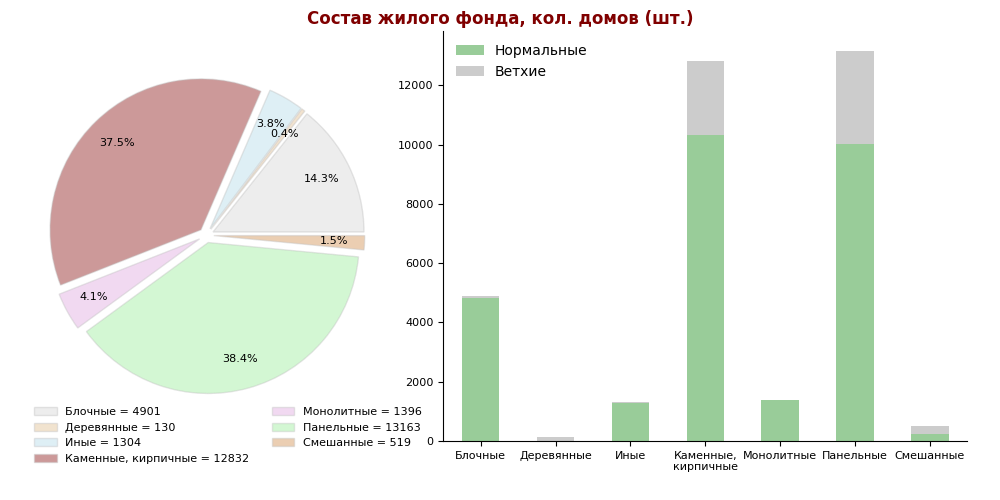

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [297]:
figHsCNT=plt.figure(figsize=(10, 5))

struct_and_content(dataframe=dtfR1, fieldAggregate='wall_type', pic_alpha=0.4, plot_fig=figHsCNT,
                       func='size', strHead='Cостав жилого фонда, кол. домов (шт.)')

plt.tight_layout(pad=2, w_pad=1, h_pad=1)
plt.show();

<IPython.core.display.Javascript object>


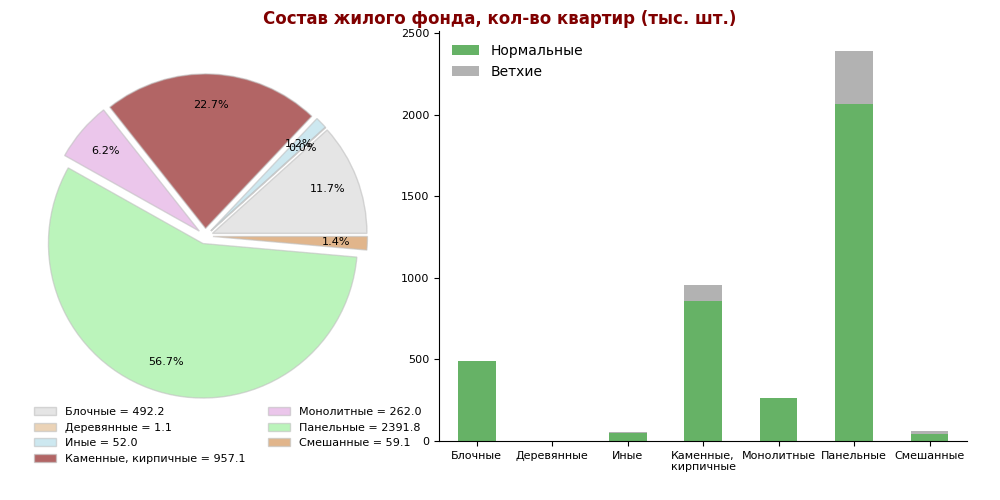

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/egor/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

In [298]:
figRoomsCNT=plt.figure(figsize=(10, 5))

struct_and_content(dataframe=dtfR1, fieldAggregate='rooms', pic_alpha=0.6, plot_fig=figRoomsCNT,
                       func='sum', strHead='Cостав жилого фонда, кол-во квартир (тыс. шт.)', scale=1000, dec=1)

plt.tight_layout(pad=2, w_pad=1, h_pad=1)
plt.show();

<IPython.core.display.Javascript object>


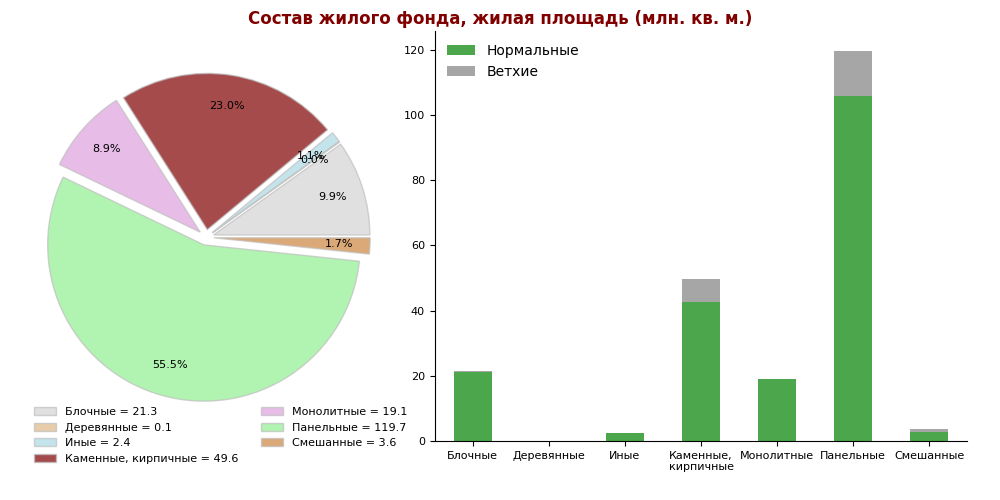

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/egor/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

In [299]:
figLivSquare=plt.figure(figsize=(10, 5))

struct_and_content(dataframe=dtfR1, fieldAggregate='living_square', pic_alpha=0.7, plot_fig=figLivSquare,
                       func='sum', strHead='Cостав жилого фонда, жилая площадь (млн. кв. м.)', scale=1e6, dec=1)

plt.tight_layout(pad=2, w_pad=1, h_pad=1)
plt.show();

### По годам постройки

<IPython.core.display.Javascript object>


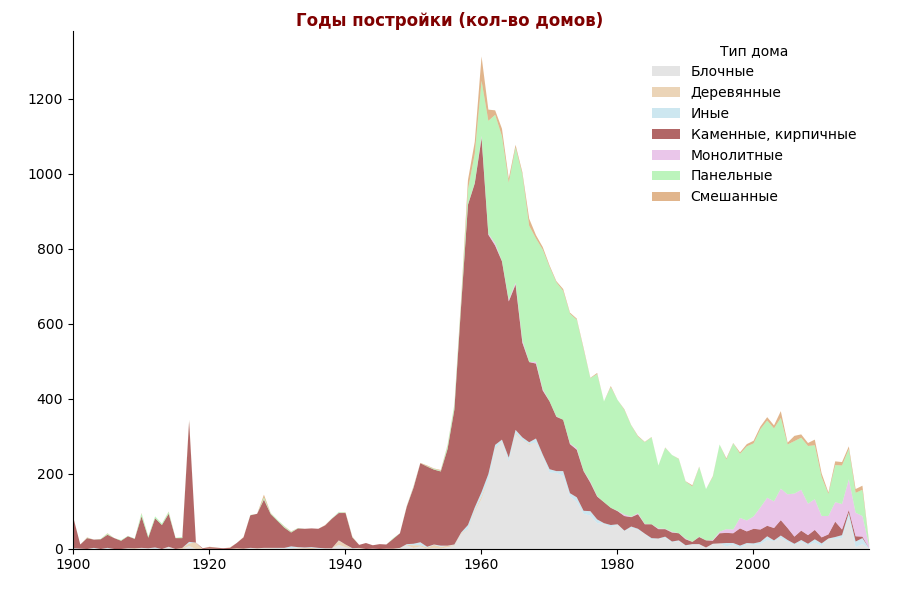

In [308]:
_dtmp=dtfR1[['wall_type', 'year']]
#print(_dtmp)
dBY = pd.pivot_table(_dtmp.reset_index(), values='id', index='year',
                     columns=['wall_type'], aggfunc=np.size).reset_index()


figBY, axBY=plt.subplots(figsize=(9, 6))
figBY.suptitle('Годы постройки (кол-во домов)', fontsize=12, color='maroon', fontweight='bold')

dBY[dBY['year']>=1900].set_index('year').plot.area(ax=axBY, alpha=0.6, stacked=True, 
                                                   color=('lightgray', 'burlywood', 'lightblue', 'maroon', 'plum', 'lightgreen', 'peru'), linewidth=0)
axBY.legend_.set_title('Тип дома')
axBY.legend_.set_frame_on(False)
axBY.set_xlabel('')
plt.tight_layout(pad=2)

axBY.spines['top'].set_visible(False)
axBY.spines['right'].set_visible(False)


plt.show();

<IPython.core.display.Javascript object>


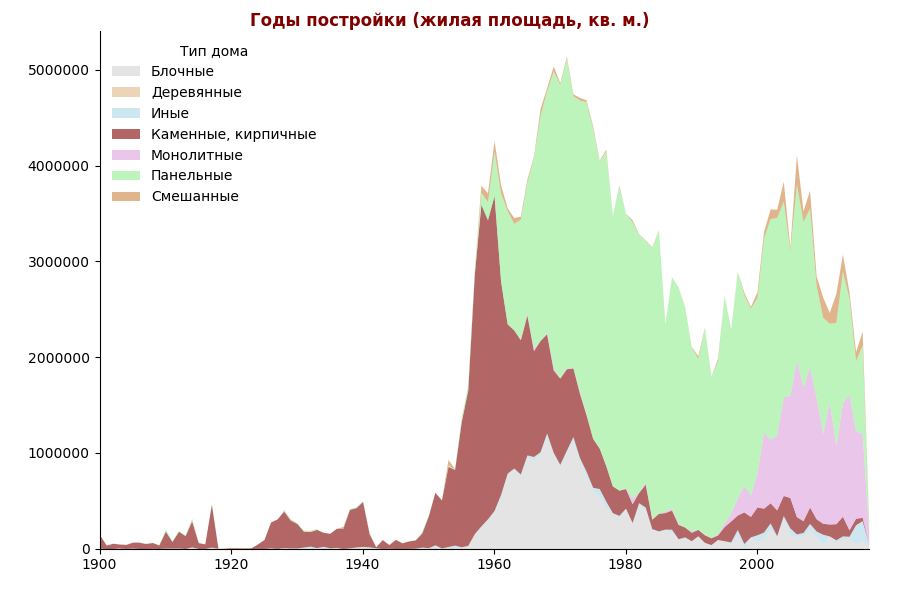

In [307]:
_dtmp=dtfR1[['wall_type', 'year', 'living_square']]
#print(_dtmp)
dBY = pd.pivot_table(_dtmp.reset_index(), values='living_square', index='year',
                     columns=['wall_type'], aggfunc=np.sum).reset_index()

#print(dBY)
figBY, axBY=plt.subplots(figsize=(9, 6))
figBY.suptitle('Годы постройки (жилая площадь, кв. м.)', fontsize=12, color='maroon', fontweight='bold')

dBY[dBY['year']>=1900].set_index('year').plot.area(ax=axBY, alpha=0.6, stacked=True, 
                                                   color=('lightgray', 'burlywood', 'lightblue', 'maroon', 'plum', 'lightgreen', 'peru'), linewidth=0)
axBY.legend_.set_title('Тип дома')
axBY.legend_.set_frame_on(False)
axBY.set_xlabel('')
plt.tight_layout(pad=2)

axBY.spines['top'].set_visible(False)
axBY.spines['right'].set_visible(False)


plt.show();

In [302]:
#dtmp=dtfR1[dtfR1['wall_type']=='Панельные']
#dtmp=dtfR1.ix[dtfR1['address'].str.contains('ш. Варшавское, д. 144')]
dtmp=dtfR1.ix[(dtfR1['wall_type'].str.contains('Деревянные')) & (dtfR1['year']).isin(range(1890, 1910))]
#dtmp=dtfR1.ix[(dtfR1['seria'].str.contains('II-49'))]

print(dtmp.sort_values(by='living_square', ascending=False))
#'индивидуальный', 'Индивидуальный проект', 'ИНД', 'Индив.'

                             address    year floors seria  \
id                                                          
8246602       ш. Дмитровское, д. 172  1898.0      1   ИНД   
7683582  ул. Василия Ботылева, д. 15  1909.0      1   ИНД   
7584815            ул. Камова, д. 33  1908.0      1   ИНД   
7683572  ул. Василия Ботылева, д. 11  1909.0      1   ИНД   

                        type   wall_type   latitude  longtitude  wreck  rooms  \
id                                                                              
8246602  Многоквартирный дом  Деревянные  55.943235   37.546552  False    3.0   
7683582  Многоквартирный дом  Деревянные  55.783686   37.350288  False    4.0   
7584815  Многоквартирный дом  Деревянные  55.701369   37.877527  False    3.0   
7683572  Многоквартирный дом  Деревянные  55.783296   37.349794  False    2.0   

         living_square common_hold_square   kam type_kam      tear tear_cat  
id                                                                  

## Посмотрим отношение ветхих и нормальных домой сейчас и в будущем

In [303]:
#d_aging = dtfR1[['year', 'wall_type', 'wreck', 'rooms', 'living_square',  'tear']]
d_aging = dtfR1[['year', 'wall_type', 'wreck', 'tear', 'kam', 'living_square', 'rooms']]
d_aging['living_square'].replace('Не заполнено', np.nan, inplace=True)
d_aging['living_square'].astype(float)
#d_aging['rooms'].replace('Не заполнено', np.nan, inplace=True)

d_aging=d_aging[d_aging['kam'].notnull()]

all_living_square = d_aging['living_square'].sum()
all_rooms=d_aging['rooms'].sum()

lYear_how_far=5 # шагов вперед
lYear_step_size=6 # шаг = lYear_step_size лет

lst_points=list(range(dt.now().year, dt.now().year+lYear_step_size*lYear_how_far, lYear_step_size))

dct_imp_years={2018:'Выборы Путина', 2025:'Горизонт среднесрочного прогноза', 
               2035:'Горизонт долгосрочного прогноза'}

def make_aging_df(d, points,  strField, asSum=False):
    for y in points:
        if asSum:
            d[y]=(calc_aging_koef(y, d)>=k_dila).astype(float)*d[strField]
        else:
            d[y]=(calc_aging_koef(y, d)>=k_dila).astype(float)
        d.ix[d['wreck'], 'tear']=1
    return d

#d_plt=make_aging_df(d_aging, lst_points, 'living_square', asSum=True).dropna()[lst_points+['wall_type']]
d_plt=make_aging_df(d_aging, lst_points, 'living_square', asSum=False)[lst_points+['wall_type']]
#dd=d_plt.sort_values(by='year')

print(d_plt['wall_type'].unique().tolist())
#print(dd.ix[dd['wall_type']=='Каменные, кирпичные'])

/home/egor/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


['Каменные, кирпичные', 'Панельные', 'Иные', 'Монолитные', 'Деревянные', 'Блочные', 'Смешанные']


<IPython.core.display.Javascript object>


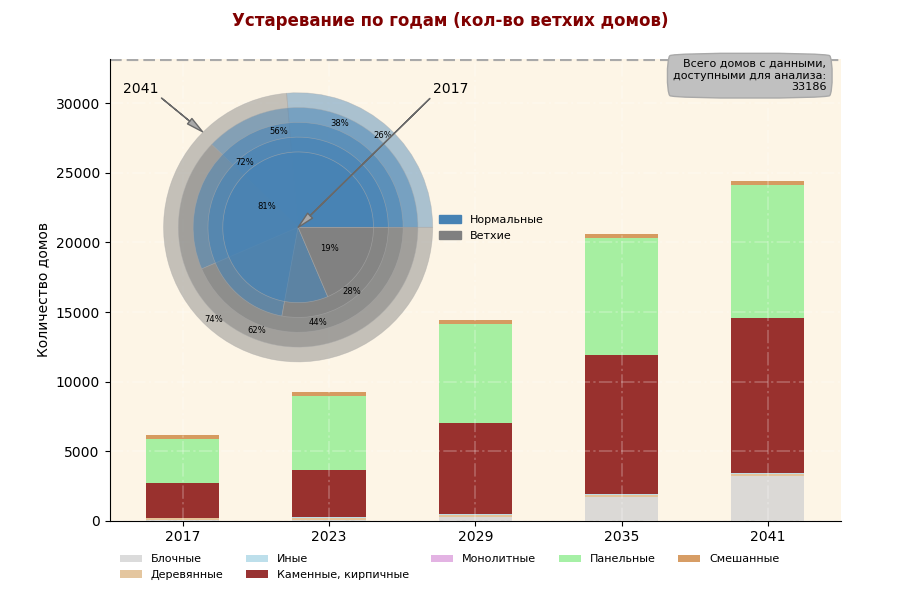

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:79: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [304]:
import matplotlib.patches as mptch

figAGE_cnt, axAGE_cnt=plt.subplots(figsize=(9, 6))


def plot_pie(dtf=d_plt, axP=None, points=lst_points):
    pie_colors=('steelblue', 'gray')
    for i, y in enumerate(reversed(lst_points)):
        if y!=lst_points[0]:
            pd=0.93
            c='darkgray'
        else:
            pd=0.5
            c='black'
        d=dtf.groupby(by=y).agg('size') #d_plt.groupby(by=y)[y].size()
        d.plot.pie(ax=axP, labels=None, pctdistance=pd, colors=pie_colors, 
           wedgeprops={'alpha':0.45+i*0.05, 'linewidth': 0.5, 'edgecolor':'darkgray'}, radius=1-i*0.11,
           autopct='%1.0f%%', fontsize=6, startangle=0)
    axP.set_ylabel('')
    axP.axis('equal')
    
    hdlNorm=mptch.Patch(color=pie_colors[0], label='Нормальные')
    hdlVth=mptch.Patch(color=pie_colors[1], label='Ветхие')

    axP.legend([hdlNorm,hdlVth],['Нормальные','Ветхие'], loc=7, fontsize=8, framealpha=0)
    axP.legend_.set_bbox_to_anchor((1.07, 0.5))
    
    axP.annotate(lst_points[0], xy=(0, 0), xytext=(1, 1), 
              arrowprops=dict(facecolor='darkgray', shrink=0, width=0.05, headwidth=5, edgecolor='dimgray'))

    axP.annotate(lst_points[-1], xy=(-0.71, 0.71), xytext=(-1.3, 1), 
              arrowprops=dict(facecolor='darkgray', shrink=0, width=0.05, headwidth=5, edgecolor='dimgray'))
    
    return axP

def plot_aging(df_plotbars=d_plt.groupby(by='wall_type').sum().T, df_plot_pie=d_plt, 
               fieldAggregate='wall_type', 
              strCaption='Уcтаревание по годам (кол-во ветхих домов)', strYLabel='Количество домов',
              scale=1e6, dec=1, axAGE=axAGE_cnt, figAGE=figAGE_cnt, y_max=len(d_plt.index),
              label_max='Всего домов с данными,\nдоступными для анализа:\n{}', pie_plot_function=plot_pie):

    figAGE.suptitle(strCaption, fontsize=12, color='maroon', fontweight='bold')
    axAGE=df_plotbars.plot.bar(stacked=True, ax=axAGE, rot=0, alpha=0.8,
                                               color=bar_colors)

    plt.tight_layout(pad=4)
    
    aPie=plt.axes([0.08, 0.37, .5, .5])
    pie_plot_function(axP=aPie)

    hdls, lbls = axAGE.get_legend_handles_labels()
    axAGE.legend(hdls, lbls, ncol=5, loc=3, fontsize=8)

    axAGE.legend_.set_title(None)

    axAGE.legend_.set_frame_on(False)

    axAGE.legend_.set_bbox_to_anchor((0, -0.15))

    axAGE.spines['top'].set_visible(False)
    axAGE.spines['right'].set_visible(False)

    axAGE.set_ylabel(strYLabel)
    axAGE.set_ylim(0, y_max)

    #axis_to_data=axAGE.transAxes + axAGE.transData.inverted()
    #data_to_axis=axis_to_data.inverted()

    

    axAGE.axhline(y=y_max, linewidth=3, color='darkgray', ls='--')

#axAGE.annotate('Всего домов с данными,\nдоступными для анализа:\n{}'.format(len(d_plt.index)), xy=(7, len(d_plt.index)), xytext=(5, 10000), 
#              arrowprops=dict(facecolor='darkgray', shrink=0, width=0.05, headwidth=5, edgecolor='dimgray'), fontsize=8)

    t_ano=axAGE.text(lYear_how_far-0.6, y_max, label_max.format(y_max), 
                ha='right', va='top', bbox={'boxstyle':'round4,pad=0.6', 'fc':'silver', 'ec':'darkgray'}, fontsize=8)

    axAGE.set_axis_bgcolor('oldlace')
    axAGE.grid(color='w', linestyle='-.', linewidth=0.3)
    
plot_aging()

plt.show();

<IPython.core.display.Javascript object>


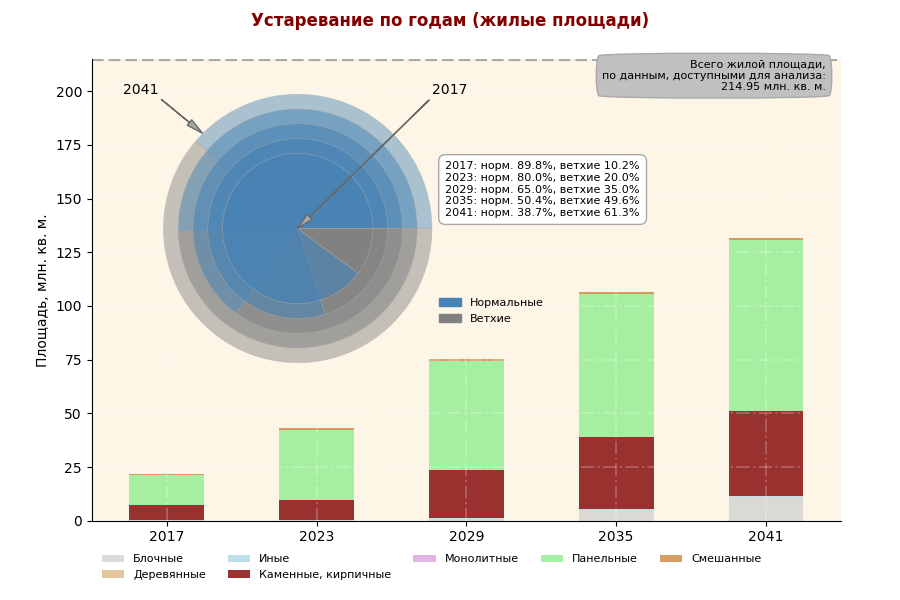

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:79: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [305]:
figAGE_sqr, axAGE_sqt=plt.subplots(figsize=(9, 6))

d_plt_sqrt=make_aging_df(d_aging, lst_points, 'living_square', asSum=True)[lst_points+['wall_type']]

#d_plt_sqrt=d_plt_sqrt[d_plt_sqrt['wall_type']=='Панельные']

def plot_pie_sqrt(dtf=d_plt_sqrt, axP=None, points=lst_points, all_sqrt=all_living_square):
    def calc_proc(x):
        return x/all_sqrt
    
    pie_colors=('steelblue', 'gray')
        
    hdlExpl=mptch.Patch(color='Gainsboro')
    hdlNorm=mptch.Patch(color=pie_colors[0])
    hdlVth=mptch.Patch(color=pie_colors[1])
    lstAno=list()
    
    for i, y in enumerate(reversed(lst_points)):
               
        f_bad=dtf[y].sum()
        lst=[all_sqrt-f_bad, f_bad]
        strAno='{0}: норм. {1:.1%}, ветхие {2:.1%}'.format(y, calc_proc(lst[0]), calc_proc(lst[1]))
        lstAno.insert(0, strAno)
        sr=pd.Series(lst)
        
        sr.plot.pie(ax=axP, labels=None, colors=pie_colors, 
           wedgeprops={'alpha':0.45+i*0.05, 'linewidth': 0.5, 'edgecolor':'darkgray'}, radius=1-i*0.11,
           autopct=None, fontsize=6, startangle=0)
        
    t_ano=axP.text(1.1, 0.5, '\n'.join(lstAno), 
                ha='left', va='top', bbox={'boxstyle':'round,pad=0.6', 'fc':'white', 'ec':'darkgray'}, fontsize=8)

    axP.set_ylabel('')
    axP.axis('equal')

    axP.legend([hdlNorm, hdlVth],['Нормальные', 'Ветхие'], loc=1, fontsize=8, framealpha=0)
    axP.legend_.set_bbox_to_anchor((1.07, 0.3))
    
    axP.annotate(lst_points[0], xy=(0, 0), xytext=(1, 1), 
              arrowprops=dict(facecolor='darkgray', shrink=0, width=0.05, headwidth=5, edgecolor='dimgray'))

    axP.annotate(lst_points[-1], xy=(-0.71, 0.71), xytext=(-1.3, 1), 
              arrowprops=dict(facecolor='darkgray', shrink=0, width=0.05, headwidth=5, edgecolor='dimgray'))
    return axP

scale_sqrt=1e-6

plot_aging(df_plotbars=d_plt_sqrt.groupby(by='wall_type').sum().applymap(lambda x: x*scale_sqrt).T, 
           fieldAggregate='living_square', 
           strCaption='Уcтаревание по годам (жилые площади)', strYLabel='Площадь, млн. кв. м.',
           scale=1e6, dec=1, axAGE=axAGE_sqt, figAGE=figAGE_sqr, y_max=all_living_square*scale_sqrt, 
           label_max='Всего жилой площади,\nпо данным, доступными для анализа:\n{:.2f} млн. кв. м.', 
           pie_plot_function=plot_pie_sqrt)

plt.show();

<IPython.core.display.Javascript object>


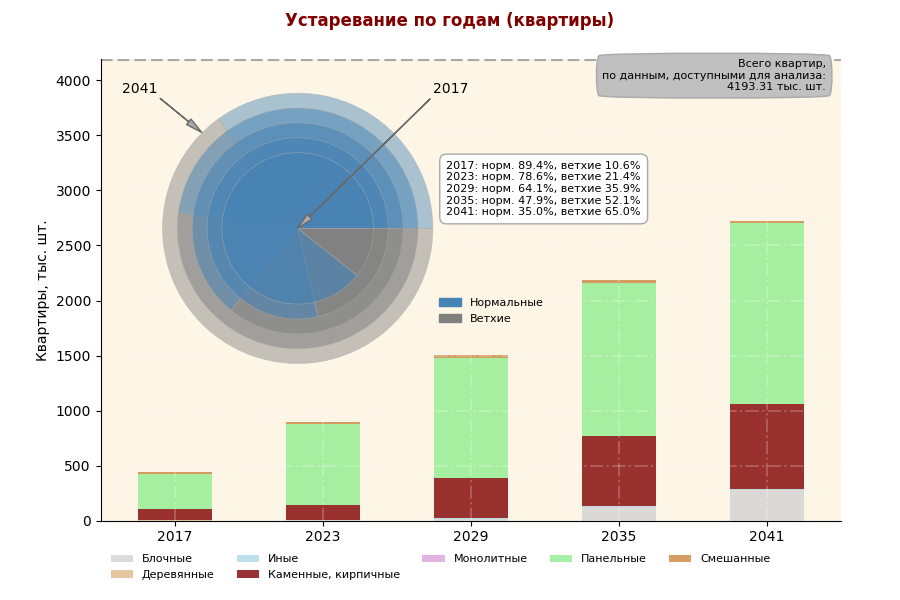

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:79: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [306]:
figAGE_rm, axAGE_rm=plt.subplots(figsize=(9, 6))

d_plt_rooms=make_aging_df(d_aging, lst_points, 'rooms', asSum=True)[lst_points+['wall_type']]

d_plt_rooms=d_plt_rooms.dropna()

def plot_pie_rooms(dtf=d_plt_rooms, axP=None, points=lst_points, all_sqrt=all_rooms):
    def calc_proc(x):
        return x/all_sqrt
    
    pie_colors=('steelblue', 'gray')
        
    hdlExpl=mptch.Patch(color='Gainsboro')
    hdlNorm=mptch.Patch(color=pie_colors[0])
    hdlVth=mptch.Patch(color=pie_colors[1])
    lstAno=list()
    
    for i, y in enumerate(reversed(lst_points)):
               
        f_bad=dtf[y].sum()
        lst=[all_sqrt-f_bad, f_bad]
        strAno='{0}: норм. {1:.1%}, ветхие {2:.1%}'.format(y, calc_proc(lst[0]), calc_proc(lst[1]))
        lstAno.insert(0, strAno)
        sr=pd.Series(lst)
        
        sr.plot.pie(ax=axP, labels=None, colors=pie_colors, 
           wedgeprops={'alpha':0.45+i*0.05, 'linewidth': 0.5, 'edgecolor':'darkgray'}, radius=1-i*0.11,
           autopct=None, fontsize=6, startangle=0)
        
    t_ano=axP.text(1.1, 0.5, '\n'.join(lstAno), 
                ha='left', va='top', bbox={'boxstyle':'round,pad=0.6', 'fc':'white', 'ec':'darkgray'}, fontsize=8)

    axP.set_ylabel('')
    axP.axis('equal')

    axP.legend([hdlNorm, hdlVth],['Нормальные', 'Ветхие'], loc=1, fontsize=8, framealpha=0)
    axP.legend_.set_bbox_to_anchor((1.07, 0.3))
    
    axP.annotate(lst_points[0], xy=(0, 0), xytext=(1, 1), 
              arrowprops=dict(facecolor='darkgray', shrink=0, width=0.05, headwidth=5, edgecolor='dimgray'))

    axP.annotate(lst_points[-1],xy=(-0.71, 0.71), xytext=(-1.3, 1), 
              arrowprops=dict(facecolor='darkgray', shrink=0, width=0.05, headwidth=5, edgecolor='dimgray'))
    
    return axP

scale_rooms=1e-3

plot_aging(df_plotbars=d_plt_rooms.groupby(by='wall_type').sum().applymap(lambda x: x*scale_rooms).T, 
           fieldAggregate='rooms', 
           strCaption='Уcтаревание по годам (квартиры)', strYLabel='Квартиры, тыс. шт.',
           scale=1e3, dec=1, axAGE=axAGE_rm, figAGE=figAGE_rm, y_max=all_rooms*scale_rooms, 
           label_max='Всего квартир,\nпо данным, доступными для анализа:\n{:.2f} тыс. шт.', 
           pie_plot_function=plot_pie_rooms)

plt.show();